In [3]:
import pandas as pd
import json
import re
import tifffile as tiff
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

import cv2 

from sklearn.linear_model import LinearRegression


In [2]:
with tiff.TiffFile('4-2.tif') as tif:
    frames = tif.asarray()

In [20]:
def initialBackgroundv2(frame: np.array)->np.array:
    """ 
    Performs background subtraction

    Args:
    -----
    - `frame`: the one frame we want to create the background from

    Output:
    -------
    The background of the image
    """
    
    L = frame.shape[0] // 2
    
    ## detect big lines and zone above or below (will simply set them as the background
    # --> big assumption here)

    test = np.sum(frame, axis = 1)
    thresh = np.min(test) * 6               # some arbritrary threshold
    ids = np.where(test < thresh)[0]        # y ids of the lines

    idMin = ids[ids < L]
    idMax = ids[ids > L]
    maxIdMin = np.max(idMin)
    minIdMax = np.min(idMax)

    idMin = np.arange(maxIdMin+1)
    idMax = np.arange(minIdMax, frame.shape[0])

    ## tackle the middle part
    ## model the horizontal color shift
    ## delete those values in the computation from the initial frame
    linearIdsList = np.random.randint(0, frame.shape[0], 5)     # 5 lines for linear model, (5 is arbritrary) ...

    y = None

    for i in range(len(linearIdsList)):
        if linearIdsList[i] in idMin or linearIdsList[i] in idMax:
            if linearIdsList[i] < L:
                linearIdsList[i] += np.random.randint(40, L)    #just to get it off the zone
            else:
                linearIdsList[i] -= np.random.randint(40, L)    # just to get it off the zone
        
        if y is None:
            y = frame[i, :].reshape(1, -1)
        else:
            y = np.vstack((y, frame[i, :]))

    X = np.tile(np.arange(frame.shape[1])[np.newaxis, :], (len(linearIdsList), 1))


    model = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))
    preds = model.predict(np.arange(frame.shape[1]).reshape(-1,1)).reshape(1,-1)
    bg = np.tile(preds, (frame.shape[0], 1))
    
    # replace the two other zone
    bg[idMin, :] = frame[idMin, :]
    bg[idMax, :] = frame[idMax, :]
    bg = bg.astype(int)

    return bg


In [27]:
bg2 = initialBackgroundv2(frames[0][:, :, 0])
bg = np.tile(bg2[:, :, np.newaxis], (1,1,3))

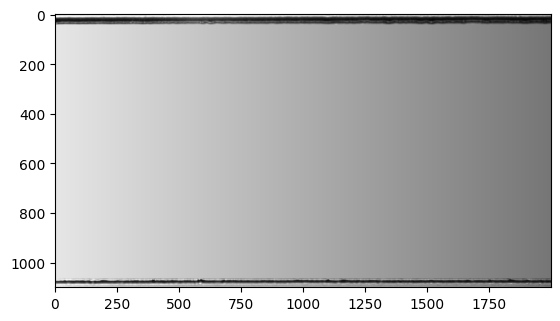

In [39]:
plt.imshow(bg)
plt.show()

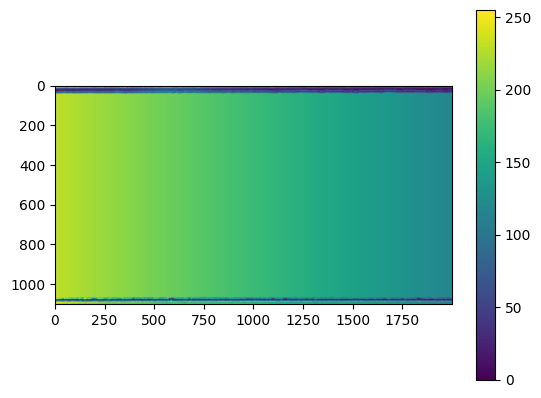

In [40]:
plt.imshow(bg2)
plt.colorbar()
plt.show()

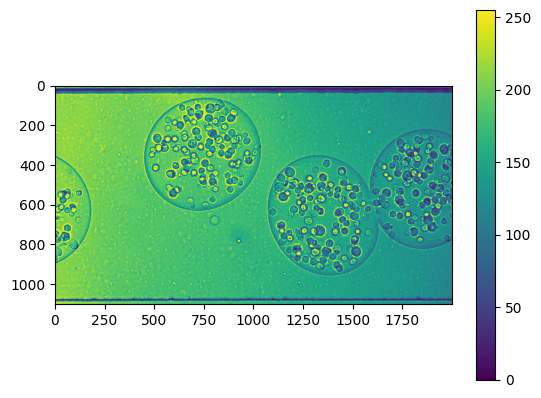

In [41]:
plt.imshow(frames[0][:, :, 0])
plt.colorbar()
plt.show()

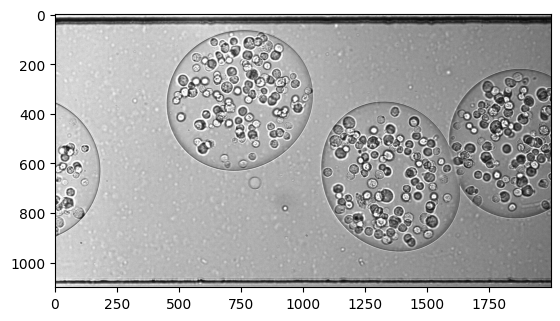

In [29]:
plt.imshow(frames[0])

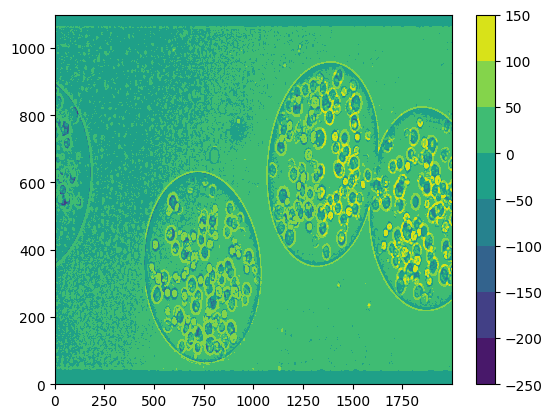

In [36]:
plt.contourf(frames[0][:, :, 0] - bg[:, :, 0])
plt.colorbar()

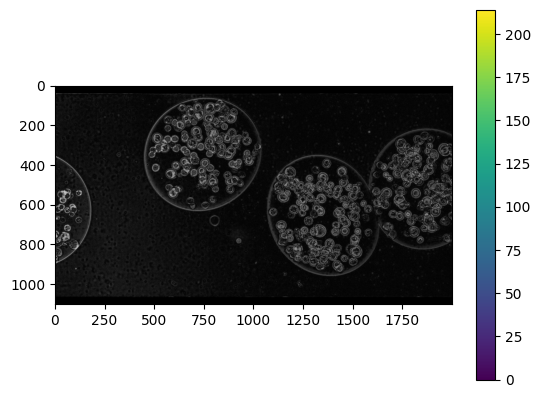

In [34]:
plt.imshow(np.abs(frames[0] - bg))
plt.colorbar()
plt.show()